In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

For this section, we'll design a Neural Network to predict the genre of a film based off of numerical values.

In [2]:
df = pd.read_csv("./data/nan_removed_cleaned_data.csv")

# Convert our datetime objects to Unix timestamps
df['release_unix'] = pd.to_datetime(df['release_date'])
df['release_unix'] = df.release_unix.values.astype(np.int64) // 10 ** 9

# This will set the first_genre to the first genre that appears in the list of genres 
df['first_genre'] = df.apply(lambda row: row['genres'].strip('[]').replace("'", '').replace(' ', '').split(',')[0], axis=1)

# Remove any rows that have 'None' as their genre. We will regard these as missing values
df = df[df['first_genre'] != 'None']

Now, let's cut our problem down to just 3 genres, since the other genres are a bit too obscure according to this data:

In [3]:
df['first_genre'].value_counts()

Drama             2969
Comedy            2315
Horror            1673
Documentary       1541
Action            1196
Thriller           622
Crime              454
Adventure          411
ScienceFiction     357
Animation          290
Romance            253
Music              224
Fantasy            221
Family             191
Mystery            141
Western            132
War                 67
History             61
TVMovie             49
Name: first_genre, dtype: int64

In [4]:
df = df[(df['first_genre'] == 'Drama') | (df['first_genre'] == 'Comedy') | (df['first_genre'] == 'Documentary')]

# Extract the unique genres
unique_genres = df['first_genre'].unique()
# Assign an integer to each genre
genre_dict = {}
for idx, i in enumerate(unique_genres):
    genre_dict[i] = idx

df['genre_int'] = df.apply(lambda row: genre_dict[row['first_genre']], axis=1)

display(df['first_genre'].value_counts())

df[['genre_int', 'first_genre']].sample(10)

Drama          2969
Comedy         2315
Documentary    1541
Name: first_genre, dtype: int64

,genre_int,first_genre
10335,0,Documentary
7845,1,Drama
13899,2,Comedy
534,2,Comedy
7574,2,Comedy
11960,1,Drama
12773,2,Comedy
14339,2,Comedy
5753,1,Drama
6910,1,Drama


Great! Now we have integer labels to predict on.

In [5]:
df.columns

Index(['budget', 'genres', 'id', 'imdb_id', 'original_title', 'overview',
       'popularity', 'poster_path', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'log_popularity', 'title_length', 'num_languages', 'num_genres',
       'imdb_rating', 'imdb_budget', 'imdb_revenue', 'budget_currency',
       'revenue_currency', 'converted_budget', 'converted_revenue',
       'combined_budget', 'combined_revenue', 'release_unix', 'first_genre',
       'genre_int'],
      dtype='object')

Now, we want to only extract the columns that will be relevant to our Neural Network prediction.

Namely, numeric values that aren't unimportant (i.e. not id, etc.)

In [6]:
df = df[['runtime', 'vote_average', 'vote_count', 'log_popularity', 'title_length', 'num_languages',
          'num_genres', 'imdb_rating', 'combined_budget', 'combined_revenue', 'release_unix', 'genre_int']]

# Next, remove any missing data
df.dropna(inplace=True)

Now that we have our finalized dataset, we can separate it into training and testing.

In [7]:
# Separate into train and test
train = df.sample(frac=0.8,random_state=1612)
test = df.drop(train.index)

display(train.head(5))
display(test.head(5))

# Extract y vs. x
train_y = train['genre_int'].to_numpy()
test_y = test['genre_int'].to_numpy()
train_x = train.drop('genre_int', axis=1).to_numpy()
test_x = test.drop('genre_int', axis=1).to_numpy()

display(np.unique(train_y, return_counts=True))
display(np.unique(test_y, return_counts=True))

display(train_x.shape)

,runtime,vote_average,vote_count,log_popularity,title_length,num_languages,num_genres,imdb_rating,combined_budget,combined_revenue,release_unix,genre_int
9416,60,6.5,7,0.518794,8,1,1,6.3,2.430930e+05,0.0,-1210550400,2
5504,72,6.4,28,0.898534,10,2,1,6.7,5.390000e+02,28731.0,-267321600,1
10094,89,3.7,7,1.094604,17,1,4,3.8,7.000000e+05,0.0,1443657600,1
8196,77,6.0,1,0.470004,11,1,1,6.8,1.083920e+03,0.0,1179014400,2
939,114,5.2,353,2.077440,8,1,2,4.9,6.000000e+07,12069719.0,907804800,1


,runtime,vote_average,vote_count,log_popularity,title_length,num_languages,num_genres,imdb_rating,combined_budget,combined_revenue,release_unix,genre_int
7,91,7.400,88,2.077690,18,1,1,7.6,5.000000e+04,10233.0,-111974400,0
17,110,7.588,3407,2.999525,12,1,3,7.7,5.000000e+06,109281640.5,970099200,1
34,133,7.780,618,2.982495,30,4,2,8.1,1.324432e+06,3270000.0,-1252108800,1
50,130,7.468,2579,2.898450,20,4,3,7.7,1.800000e+07,42176743.5,527904000,1
55,89,6.600,21,1.356608,14,1,1,5.7,5.630054e+06,0.0,1041379200,1


(array([0, 1, 2], dtype=int64), array([1017, 2154, 1729], dtype=int64))

(array([0, 1, 2], dtype=int64), array([245, 547, 433], dtype=int64))

(4900, 11)

Awesome! Now we have separation, **and** both our train and test sets have examples of each genre.

Notice that we have 5 classes.

Now that we have all of our data, we can set up a Neural Network to train and (hopefully) predict between these 5 classes.

First, set up our various training-specific variables:

In [8]:
# Activation function to use for our inner layers
act = 'relu'

# Learning rate
lr = 0.0005

# Number of epochs
epochs = 100

# Loss function - Here we're using a modified version 
# of cross-entropy for multi-class classification.
loss_fun = losses.SparseCategoricalCrossentropy(from_logits=True)

# Number of prediction classes:
n_classes = len(np.unique(train_y))

Next, we notice from previously that the amount of samples of each class is quite skewed. This will significantly decrease the performance of our model, so TensorFlow lets us assign class weights to each class.

(see https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights)

In [9]:
_, counts = np.unique(train_y, return_counts=True)
class_weights = {}
for idx, i in enumerate(counts):
    class_weights[idx] = (1 / i) * (train_y.shape[0] / n_classes)

display(class_weights)

{0: 1.6060308095706326, 1: 0.7582791705354379, 2: 0.9446693657219972}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 21,251
Trainable params: 21,251
Non-traina

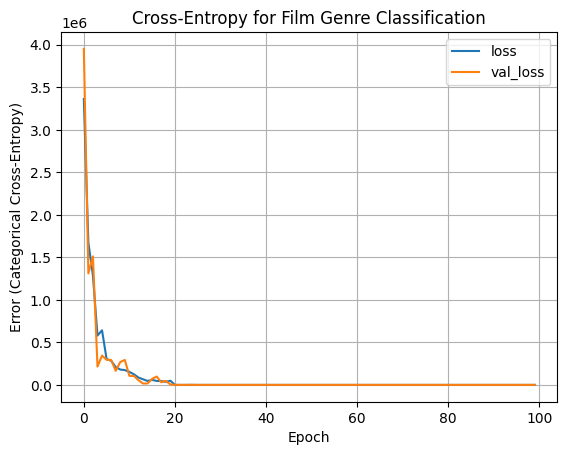

39/39 [==============================] - 0s 1ms/step - loss: 13.6252 - accuracy: 0.3551
[13.625152587890625, 0.3551020324230194]


In [10]:
# Setting up our network for multi-class classification

model = keras.Sequential([
    # Input layer - takes in the 12 predictors
    layers.InputLayer(input_shape=(train_x.shape[1],)),
    # Normalize our inputs
    #layers.Normalization(axis=-1),
    # 2 Hidden layers, each with 32 units
    layers.Dense(32, activation=act),
    layers.Dense(64, activation=act),
    layers.Dense(128, activation=act),
    layers.Dense(64, activation=act),
    layers.Dense(32, activation=act),
    # Predict one of the classes
    layers.Dense(n_classes)])

# Print a summary of the model
model.summary()

# Compile, using the Adam optimizer for learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=loss_fun, metrics=['accuracy'])

'''
The following is TensorFlow-specific.
This just sets up a checkpointer to save our progress throughout the training.
'''

# Set up the checkpointing
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

'''
END
'''

# Train the model
history = model.fit(train_x, train_y, epochs=epochs, batch_size=8,
                    validation_split=0.25, callbacks=[cp_callback], class_weight=class_weights)

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error (Categorical Cross-Entropy)')
    plt.title('Cross-Entropy for Film Genre Classification')
    plt.legend()
    plt.grid(True)
    plt.savefig('./imgs/nn_ims/training_loss.png')
    plt.show()

# Plot the loss
plot_loss(history)

# Evaluate on the withheld test data
test_result = model.evaluate(test_x, test_y)
print(test_result)

Great, now that we've trained our model, we can evaluate it on our test set.

39/39 [==============================] - 0s 1ms/step


array([[0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382],
       [0.33179682, 0.3340593 , 0.33414382]], dtype=float32)

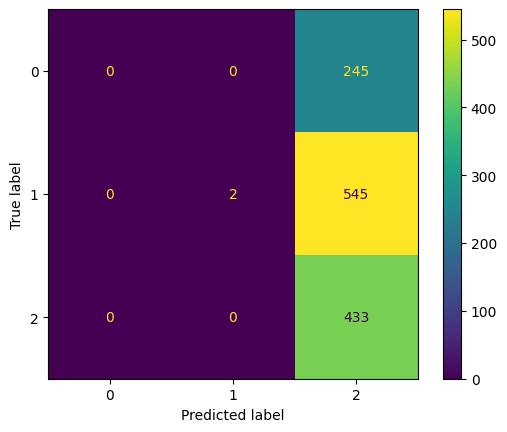

Test accuracy: 0.3551020408163265


In [11]:
pred_model = keras.Sequential([model, layers.Softmax()])

test_pred = pred_model.predict(test_x)

# Randomly sample 10 predicted softmax outputs
index = np.random.choice(test_pred.shape[0], 10, replace=False)

display(test_pred[index])

test_pred_vals = np.argmax(test_pred, axis=1)

cn_matrix = confusion_matrix(test_y, test_pred_vals)
disp = ConfusionMatrixDisplay(cn_matrix)
disp.plot()
plt.savefig('./imgs/nn_ims/confusion_matrix.png')
plt.show()

print(f"Test accuracy: {accuracy_score(test_y, test_pred_vals)}")

Notice above that we don't do much better than just predicting randomly. This is interesting, and suggests that we may just be dealing with data that can't be predicted on. After **various** tweaks and attempts to get better performance, the model always tended toward this type of distribution, suggesting that the ideal loss minimization is to slightly prioritize one class over another.